In [ ]:
# 1. 挂载 Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 安装最新版 TSFEL
!pip install tsfel

In [ ]:
import os
import pandas as pd
import tsfel
import numpy as np
from scipy.fft import fft

# 设置文件路径和需要提取的列
folder_path = "/content/drive/My Drive/final_project/smooth_data4"
columns_of_interest = ["Acc_X", "Acc_Y", "Acc_Z", "FreeAcc_E", "FreeAcc_N", "FreeAcc_U",
                       "Gyr_X", "Gyr_Y", "Gyr_Z", "Roll", "Pitch", "Yaw"]

# 使用tsfel
cfg = tsfel.get_features_by_domain()
all_features = []

# 滑动窗口参数
window_size = 5 * 40  # 5秒，40Hz采样率
overlap = 0.5  # 50%重叠
step_size = int(window_size * (1 - overlap))

# 读取文件并按subject分组（例如：T11_M10_WT0）
files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
grouped_files = {}

for f in files:
    base = f.replace("_ankle.csv", "").replace("_wrist.csv", "")
    grouped_files.setdefault(base, {})
    if "ankle" in f:
        grouped_files[base]["ankle"] = f
    elif "wrist" in f:
        grouped_files[base]["wrist"] = f

# 处理每个(ankle + wrist)
for base, sensors in grouped_files.items():
    # 存储特征
    feature_dicts = []

    for sensor in ["ankle", "wrist"]:
        if sensor in sensors:
            file_path = os.path.join(folder_path, sensors[sensor])
            df = pd.read_csv(file_path)

            for col in columns_of_interest:
                if col in df.columns:
                    signal = df[col].values
                    # 创建滑动窗口
                    n_samples = len(signal)
                    windows = []

                    for start in range(0, n_samples - window_size + 1, step_size):
                        end = start + window_size
                        window = signal[start:end]
                        windows.append(window)

                    # 提取每个窗口的特征
                    for i, window in enumerate(windows):
                        if i >= len(feature_dicts):
                            feature_dicts.append({"filename": f"{base}_window{i}"})

                        # 使用TSFEL提取特征
                        features = tsfel.time_series_features_extractor(cfg, window, verbose=0, fs=40)  # fs=40 代表40Hz采样
                        features.columns = [f"{sensor}_{col}_{c}" for c in features.columns]
                        feature_dicts[i].update(features.iloc[0].to_dict())



                        # 添加额外的特征 - Jerk
                        if len(window.shape) == 1:  # 如果 window 是一维数组，将其转换为二维数组
                            window = np.expand_dims(window, axis=1)  # 将 window 转换为列向量

                        jerk = np.diff(window, axis=0)

                        # 如果信号有多个维度（例如 Acc_X, Acc_Y, Acc_Z），确保对每个轴的差分操作是正确的
                        if len(jerk.shape) == 1:  # 如果只有一个维度
                            jerk = np.expand_dims(jerk, axis=1)  # 转换为二维数组

                        # 添加零值以匹配原始信号大小
                        # jerk = np.hstack([np.zeros((1, jerk.shape[1])), jerk])
                        jerk = np.vstack([np.zeros((1, jerk.shape[1])), jerk])


                        jerk_feature = {
                            f"{sensor}_{col}_Jerk_X": np.std(jerk[:, 0]),
                            f"{sensor}_{col}_Jerk_Y": np.std(jerk[:, 1]) if jerk.shape[1] > 1 else np.nan,  # 如果有Y轴，计算Y轴Jerk
                            f"{sensor}_{col}_Jerk_Z": np.std(jerk[:, 2]) if jerk.shape[1] > 2 else np.nan   # 如果有Z轴，计算Z轴Jerk
                        }
                        feature_dicts[i].update(jerk_feature)


                        # -- Spectral Centroid
                        def spectral_centroid(signal, sampling_rate):
                            N = len(signal)
                            freqs = np.fft.fftfreq(N, d=1/sampling_rate)
                            sp = np.abs(fft(signal))
                            return np.sum(freqs * sp) / np.sum(sp)

                        spectral_centroid_feature = {
                            f"{sensor}_{col}_Spectral_Centroid": spectral_centroid(window, 40)  # 40Hz采样
                        }
                        feature_dicts[i].update(spectral_centroid_feature)

                        # -- Spectral Edge Frequency
                        def spectral_edge_frequency(signal, sampling_rate, percentile=90):
                            sp = np.abs(fft(signal))
                            energy = np.cumsum(sp) / np.sum(sp)
                            return np.where(energy >= percentile / 100)[0][0] * sampling_rate / len(signal)

                        spectral_edge_frequency_feature = {
                            f"{sensor}_{col}_Spectral_Edge_Freq": spectral_edge_frequency(window, 40)  # 40Hz采样
                        }
                        feature_dicts[i].update(spectral_edge_frequency_feature)

                        # -- Coefficient of Variation （标准差/均值）
                        cv_feature = {
                            f"{sensor}_{col}_CV": np.std(window) / np.mean(window)
                        }
                        feature_dicts[i].update(cv_feature)

    all_features.extend(feature_dicts)

# 保存到文件
features_df = pd.DataFrame(all_features)

# 保存到 Colab 输出路径
output_path = "/content/drive/My Drive/final_project/feature_engineering/features/tsfel_features_windowed_additional.csv"
features_df.to_csv(output_path, index=False)
print(f"File Saved")


File Saved: /content/drive/My Drive/final_project/feature_engineering/features/tsfel_features_windowed_additional.csv


In [ ]:
features_df

In [ ]:
# extract the 'subject' 'Activity' 'windows' info into a seperate column

import pandas as pd

# load CSV
# features_df = pd.read_csv("../features_tsfel/tsfel_features_windowed_additional.csv")
features_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/features/tsfel_features_windowed_additional.csv")


# extract subject
features_df["Subject"] = features_df["filename"].str.extract(r'T(\d+)_')[0]

# extract Activity（M10_WT0, M5）
features_df["Activity"] = features_df["filename"].str.extract(r'T\d+_((?:M\d+_WT\d+)|(?:M\d+))')[0]

# extract windows no.
features_df["Window"] = features_df["filename"].str.extract(r'_window(\d+)')[0]

# save to csv
# features_df.to_csv("../features_tsfel/tsfel_features_with_meta_new.csv", index=False)
features_df.to_csv("/content/drive/My Drive/final_project/feature_engineering/features/tsfel_features_windowed_additional_with_meta.csv", index=False)


In [ ]:
# head lines to chek
print(features_df[["filename", "Subject", "Activity", "Window"]].head())

              filename Subject Activity Window
0  T11_M10_WT2_window0      11  M10_WT2      0
1  T11_M10_WT2_window1      11  M10_WT2      1
2  T11_M10_WT2_window2      11  M10_WT2      2
3  T11_M10_WT2_window3      11  M10_WT2      3
4  T11_M10_WT2_window4      11  M10_WT2      4


------

去除多个NaN空白列。

In [ ]:
import pandas as pd

# 读取CSV文件
features_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/features/tsfel_features_windowed_additional_with_meta.csv")

# 删除指定的列
columns_to_drop = ['ankle_Acc_X_Jerk_Y', 'ankle_Acc_X_Jerk_Z', 'ankle_Acc_Y_Jerk_Y', 'ankle_Acc_Y_Jerk_Z', 'ankle_Acc_Z_Jerk_Y',
          'ankle_Acc_Z_Jerk_Z', 'ankle_FreeAcc_E_Jerk_Y', 'ankle_FreeAcc_E_Jerk_Z', 'ankle_FreeAcc_N_Jerk_Y', 'ankle_FreeAcc_N_Jerk_Z',
          'ankle_FreeAcc_U_Jerk_Y', 'ankle_FreeAcc_U_Jerk_Z', 'ankle_Gyr_X_Jerk_Y', 'ankle_Gyr_X_Jerk_Z', 'ankle_Gyr_Y_Jerk_Y',
          'ankle_Gyr_Y_Jerk_Z', 'ankle_Gyr_Z_Jerk_Y', 'ankle_Gyr_Z_Jerk_Z', 'ankle_Roll_Jerk_Y', 'ankle_Roll_Jerk_Z',
          'ankle_Pitch_Jerk_Y', 'ankle_Pitch_Jerk_Z', 'ankle_Yaw_Jerk_Y', 'ankle_Yaw_Jerk_Z',

          'wrist_Acc_X_Jerk_Y', 'wrist_Acc_X_Jerk_Z', 'wrist_Acc_Y_Jerk_Y', 'wrist_Acc_Y_Jerk_Z', 'wrist_Acc_Z_Jerk_Y',
          'wrist_Acc_Z_Jerk_Z', 'wrist_FreeAcc_E_Jerk_Y', 'wrist_FreeAcc_E_Jerk_Z', 'wrist_FreeAcc_N_Jerk_Y', 'wrist_FreeAcc_N_Jerk_Z',
          'wrist_FreeAcc_U_Jerk_Y', 'wrist_FreeAcc_U_Jerk_Z', 'wrist_Gyr_X_Jerk_Y', 'wrist_Gyr_X_Jerk_Z', 'wrist_Gyr_Y_Jerk_Y',
          'wrist_Gyr_Y_Jerk_Z', 'wrist_Gyr_Z_Jerk_Y', 'wrist_Gyr_Z_Jerk_Z', 'wrist_Roll_Jerk_Y', 'wrist_Roll_Jerk_Z',
          'wrist_Pitch_Jerk_Y', 'wrist_Pitch_Jerk_Z', 'wrist_Yaw_Jerk_Y', 'wrist_Yaw_Jerk_Z']

features_df = features_df.drop(columns=columns_to_drop)

# 保存修改后的文件
features_df.to_csv('/content/drive/My Drive/final_project/feature_engineering/features/tsfel_features_additional_meta_dropBlankCol.csv', index=False)


------------------

Merge features and demographics together

In [ ]:
# Merge features and demographics together

# Load two files
features_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/features/tsfel_features_additional_meta_dropBlankCol.csv")
demographic_df = pd.read_excel("/content/drive/My Drive/final_project/participant_demographics_table.xlsx")

# Clean demographic DataFrame
# Standardization the column name
demographic_df.columns = demographic_df.columns.str.strip().str.replace(" ", "_").str.lower()
# Extract subject number from ID
demographic_df["subject"] = demographic_df["trial_id"].str.extract(r"T(\d+)").astype(int)

# Merge using features_df['Subject'] and demographic_df['subject']
merged_df = features_df.merge(demographic_df, left_on="Subject", right_on="subject", how="left")

# Save to new file
merged_df.to_csv("/content/drive/My Drive/final_project/feature_engineering/features/tsfel_features_windowed_additional_with_demographics.csv", index=False)


In [ ]:
merged_df.head()

,filename,ankle_Acc_X_0_Absolute energy,ankle_Acc_X_0_Area under the curve,ankle_Acc_X_0_Autocorrelation,ankle_Acc_X_0_Average power,ankle_Acc_X_0_Centroid,ankle_Acc_X_0_ECDF Percentile Count_0,ankle_Acc_X_0_ECDF Percentile Count_1,ankle_Acc_X_0_ECDF Percentile_0,ankle_Acc_X_0_ECDF Percentile_1,...,dominant_side,age,height_(cm),weight_(kg),most_affected_side,hoehn_and_yahr_(stage),years_since_diagnosis,cit,updrs,subject
0,T11_M10_WT2_window0,683.417070,7.211711,2.0,137.370265,3.732416,40.0,160.0,1.095421,1.351066,...,R,70,183,92,Right,Three,6,4,71,11
1,T11_M10_WT2_window1,2695.242586,11.874405,5.0,541.757304,3.818114,40.0,160.0,0.047365,2.027687,...,R,70,183,92,Right,Three,6,4,71,11
2,T11_M10_WT2_window2,4020.027695,14.012806,4.0,808.045768,3.039217,40.0,160.0,-1.363676,1.934216,...,R,70,183,92,Right,Three,6,4,71,11
3,T11_M10_WT2_window3,7575.107793,17.711325,4.0,1522.634732,2.806753,40.0,160.0,-1.724634,2.231014,...,R,70,183,92,Right,Three,6,4,71,11
4,T11_M10_WT2_window4,12639.273864,24.312431,4.0,2540.557561,2.042383,40.0,160.0,-1.903777,3.073307,...,R,70,183,92,Right,Three,6,4,71,11


 3858 columns   
 (3906 cols, - 48 NaN cols)  

In [ ]:
merged_df

,filename,ankle_Acc_X_0_Absolute energy,ankle_Acc_X_0_Area under the curve,ankle_Acc_X_0_Autocorrelation,ankle_Acc_X_0_Average power,ankle_Acc_X_0_Centroid,ankle_Acc_X_0_ECDF Percentile Count_0,ankle_Acc_X_0_ECDF Percentile Count_1,ankle_Acc_X_0_ECDF Percentile_0,ankle_Acc_X_0_ECDF Percentile_1,...,dominant_side,age,height_(cm),weight_(kg),most_affected_side,hoehn_and_yahr_(stage),years_since_diagnosis,cit,updrs,subject
0,T11_M10_WT2_window0,683.417070,7.211711,2.0,137.370265,3.732416,40.0,160.0,1.095421,1.351066,...,R,70,183,92,Right,Three,6,4,71,11
1,T11_M10_WT2_window1,2695.242586,11.874405,5.0,541.757304,3.818114,40.0,160.0,0.047365,2.027687,...,R,70,183,92,Right,Three,6,4,71,11
2,T11_M10_WT2_window2,4020.027695,14.012806,4.0,808.045768,3.039217,40.0,160.0,-1.363676,1.934216,...,R,70,183,92,Right,Three,6,4,71,11
3,T11_M10_WT2_window3,7575.107793,17.711325,4.0,1522.634732,2.806753,40.0,160.0,-1.724634,2.231014,...,R,70,183,92,Right,Three,6,4,71,11
4,T11_M10_WT2_window4,12639.273864,24.312431,4.0,2540.557561,2.042383,40.0,160.0,-1.903777,3.073307,...,R,70,183,92,Right,Three,6,4,71,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6648,T5_M8_window27,12.704544,1.252048,3.0,2.553677,2.460104,40.0,160.0,-0.262664,-0.241773,...,L,62,170,95,Left,One,9,0,38,5
6649,T5_M8_window28,12.511088,1.242493,3.0,2.514792,2.507255,40.0,160.0,-0.262018,-0.239569,...,L,62,170,95,Left,One,9,0,38,5
6650,T5_M8_window29,12.708543,1.252169,3.0,2.554481,2.498234,40.0,160.0,-0.262710,-0.240797,...,L,62,170,95,Left,One,9,0,38,5
6651,T5_M8_window30,12.746534,1.254161,2.0,2.562117,2.479583,40.0,160.0,-0.265369,-0.241652,...,L,62,170,95,Left,One,9,0,38,5


-----


In [ ]:
# Load the merged features file
df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/features/tsfel_features_windowed_additional_with_demographics.csv")

# Calculate number of Activity completed by each Subject.
activity_counts = df.groupby("Subject")["Activity"].nunique().reset_index()
activity_counts.columns = ["Subject", "NumActivities"]

# Only keep the Subject who has complete all 12 activities.
full_activity_subjects = activity_counts[activity_counts["NumActivities"] == 12]["Subject"].tolist()

In [ ]:
# Print the results
print(f"There were {len(full_activity_subjects)} participants who completed all 12 activities")
print("Subject ID:", full_activity_subjects)

# Table show all participants and the activities they completed
activity_counts


There were 13 participants who completed all 12 activities
Subject ID: [1, 2, 3, 4, 5, 11, 12, 13, 14, 17, 18, 19, 25]


,Subject,NumActivities
0,1,12
1,2,12
2,3,12
3,4,12
4,5,12
5,11,12
6,12,12
7,13,12
8,14,12
9,17,12


-------------


Split to 'train', 'val', 'test' sets  
Use `stratify`  


In [ ]:
from sklearn.model_selection import train_test_split

# Find subjects who completed all 12 activities
activity_counts = df.groupby("Subject")["Activity"].nunique().reset_index()
full_subjects = activity_counts[activity_counts["Activity"] == 12]["Subject"].tolist()
# full_subjects = activity_counts[activity_counts["NumActivities"] == 12]["Subject"].tolist()


# Get gender info for each subject
subject_gender = df.groupby("Subject")["sex"].first().reset_index()

# Prioritise test set from full-activity group
full_df = subject_gender[subject_gender["Subject"].isin(full_subjects)]

# Calculate the number of subjects required for the test set -> 20% of total subjects
### n_test = round(subject_gender["Subject"].nunique() * 0.2)
n_total = subject_gender["Subject"].nunique()
n_test = min(round(n_total * 0.2), len(full_df))  # not exceed the number of  'full_df'


# Stratified selection from full_subjects
test_subjects, _ = train_test_split(
    full_df, test_size=len(full_df) - n_test, stratify=full_df["sex"], random_state=42
)

# Get the subjects of Non-Test Set
remaining = subject_gender[~subject_gender["Subject"].isin(test_subjects["Subject"])]

# Split remaining subjects into train and val (60% and 20%)
train_subjects, val_subjects = train_test_split(
    remaining, test_size=0.25, stratify=remaining["sex"], random_state=42
)

# Mark split in dataframe
# Add a new column in the dataframe
df["set"] = "train"
# Mark the 'set' column as 'val/test'
df.loc[df["Subject"].isin(val_subjects["Subject"]), "set"] = "val"
df.loc[df["Subject"].isin(test_subjects["Subject"]), "set"] = "test"

# Save split version of merged dataframe
# df.to_csv("../gender/features_with_demo_split_new.csv", index=False) # stage four in train
df.to_csv("/content/drive/My Drive/final_project/feature_engineering/gender/tsfel_features_addition_split.csv", index=False)

# os.makedirs("../gender_tsfel", exist_ok=True)
train_df = df[df["set"] == "train"]
val_df = df[df["set"] == "val"]
test_df = df[df["set"] == "test"]

# save train/test/val into csv files
train_df.to_csv("/content/drive/My Drive/final_project/feature_engineering/gender/train.csv", index=False)
val_df.to_csv("/content/drive/My Drive/final_project/feature_engineering/gender/val.csv", index=False)
test_df.to_csv("/content/drive/My Drive/final_project/feature_engineering/gender/test.csv", index=False)

#  Count the number of subjects in each test/val/train and gender
summary = df.groupby(["set", "sex"])["Subject"].nunique().unstack(fill_value=0)
summary["Total_Subjects"] = summary.sum(axis=1)
split_summary_df = summary.reset_index()



In [ ]:
summary

sex,F,M,Total_Subjects
set,,,
test,2,2,4
train,4,8,12
val,2,3,5


------



# Step 7

Find the best model and hyperparameters

Merge all M10(6 walk time) together:

In [ ]:
import pandas as pd

# 读取原始文件
train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender/train.csv")
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender/val.csv")
test_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender/test.csv")

# 定义 M10 替换字典
m10_merge_dict = {
    "M10_WT0": "M10", "M10_WT1": "M10", "M10_WT2": "M10",
    "M10_WT3": "M10", "M10_WT4": "M10", "M10_WT5": "M10"
}

# 替换 Activity 列中的 M10 子类为 M10
train_df["Activity"] = train_df["Activity"].replace(m10_merge_dict)
val_df["Activity"] = val_df["Activity"].replace(m10_merge_dict)
test_df["Activity"] = test_df["Activity"].replace(m10_merge_dict)

# 保存为新的文件（你可以改一下文件夹名或加后缀避免覆盖旧的）
train_df.to_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train.csv", index=False)
val_df.to_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val.csv", index=False)
test_df.to_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/test.csv", index=False)

print("done.")


------



Filled missing(NaN) value into Median value

In [ ]:
import pandas as pd

# read the file
train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train.csv")
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val.csv")

# use Median to fill in the NaN value
train_filled = train_df.fillna(train_df.median(numeric_only=True))
val_filled = val_df.fillna(val_df.median(numeric_only=True))

# save file
train_filled.to_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv", index=False)
val_filled.to_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv", index=False)


------

--------------


### Find the Best Model

#### RandomForest + SelectKBest    (RF + PCA + SelectKBest)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import LeaveOneGroupOut,GridSearchCV,RandomizedSearchCV,cross_val_predict
from sklearn.tree import DecisionTreeClassifier


# load training data
train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv")

# drop out the columns which are not features
exclude_cols = ["Activity", "Subject", "Window", "set", "trial_id",
        "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
        "age", "height_(cm)", "weight_(kg)", "most_affected_side",
        "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
        "filename", "subject"]

feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# X_train = train_df[feature_cols]
X_raw = train_df[feature_cols]
y_train = train_df["Activity"]

# create pipeline
# use standardScaler - standardize all features to mean = 0 and standard deviation = 1
# use SelectKBest to only keep top x features, remove noise features.
pipeline_new = Pipeline([
    ("vt", VarianceThreshold(threshold=0.0)),
    ("scaler", StandardScaler()),
    ("feature_selection", SelectKBest(score_func=f_classif)),
    # ("feature_selection", SelectKBest(score_func=mutual_info_classif)),
    # ("pca", PCA(n_components=0.95)),
    ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
])

# define the grid parameters
param_grid3 = {
    "feature_selection__k": [20, 30, 50, 60],
    "classifier__n_estimators": [200, 250],
    "classifier__max_depth": [2, 3, 4, 5],
    "classifier__min_samples_split": [2, 4],
    "classifier__min_samples_leaf": [2, 5, 10],  # 2/5/10 对比
    "classifier__max_features": ["sqrt", "log2"],

    # "classifier__bootstrap": [True],
    # "classifier__max_samples": [0.7, 0.8],  # 与bootstrap=True配合使用

}

# apply grid searchh
grid_search = GridSearchCV(
    estimator=pipeline_new,
    param_grid=param_grid3,
    cv=3,
    scoring="accuracy",
    # scoring="f1_macro",
    # scoring="balanced_accuracy",
    verbose=2,
    n_jobs=-1
)

# grid_search.fit(X_train, y_train)
grid_search.fit(X_raw, y_train)

# output
print("Best Hyperparameters:")
print(grid_search.best_params_)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score


best_model = grid_search.best_estimator_
# best_model = randomized_search.best_estimator_

# delete the constant features
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv")
X_val_raw = val_df[feature_cols]
y_val = val_df["Activity"]

y_pred = best_model.predict(X_val_raw)

# check the Accuracy and F1 score
train_preds = best_model.predict(X_raw)
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, y_pred)
train_f1 = f1_score(y_train, train_preds, average="macro")
val_f1 = f1_score(y_val, y_pred, average="macro")

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Train Macro F1: {train_f1:.4f}")
print(f"Val Macro F1: {val_f1:.4f}")

# ============
# check the balanced accuracy
val_bal_acc = balanced_accuracy_score(y_val, y_pred)
train_bal_acc = balanced_accuracy_score(y_train, train_preds)

print(f"\nTrain Balanced Accuracy: {train_bal_acc:.4f}")
print(f"Val Balanced Accuracy: {val_bal_acc:.4f}")
####

# classification report
print("\nClassification Report: ")
print(classification_report(y_val, y_pred))

# confusion matrix
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-----------------------

##### Random Forest + PCA =50/60 (w. BaggingClassifier)

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.feature_selection import VarianceThreshold
# from sklearn.feature_selection import mutual_info_classif
# from sklearn.decomposition import PCA
# from sklearn.model_selection import RandomizedSearchCV

# from sklearn.ensemble import BaggingClassifier

# from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.model_selection import LeaveOneGroupOut,GridSearchCV,RandomizedSearchCV,cross_val_predict
# from sklearn.tree import DecisionTreeClassifier

# # load training data
# train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv")

# # drop out the columns which are not features
# exclude_cols = ["Activity", "Subject", "Window", "set", "trial_id",
#         "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
#         "age", "height_(cm)", "weight_(kg)", "most_affected_side",
#         "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
#         "filename", "subject"]

# feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# # X_train = train_df[feature_cols]
# X_raw = train_df[feature_cols]
# y_train = train_df["Activity"]


# # create pipeline
# pipeline_new = Pipeline([
#     ("vt", VarianceThreshold(threshold=0.0)),
#     ("scaler", StandardScaler()),
#     # ("feature_selection", SelectKBest()),
#     # ("feature_selection", SelectKBest(score_func=f_classif)),
#     # ("feature_selection", SelectKBest(score_func=mutual_info_classif)),
#     # ("pca", PCA(n_components=0.95)),
#     ("pca", PCA()),
#     # ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
#     ("bagging", BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=10, random_state=42))
# ])

# # define the grid parameters
# param_grid3 = {
#     "pca__n_components": [20, 50],  # 0.95
#     "bagging__estimator__n_estimators": [200],
#     "bagging__estimator__max_depth": [2, 3],
#     "bagging__estimator__min_samples_split": [2],
#     "bagging__estimator__min_samples_leaf": [2],
#     "bagging__estimator__max_features": ["sqrt", "log2"],
#     # "bagging__estimator__bootstrap": [True],  # estimator 的 bootstrap
#     # "bagging__estimator__max_samples": [0.7, 0.8],  # estimator 的 max_samples
# }


# # apply grid searchh
# grid_search = GridSearchCV(
#     estimator=pipeline_new,
#     param_grid=param_grid3,
#     cv=3,
#     scoring="accuracy",
#     # scoring="f1_macro",
#     # scoring="balanced_accuracy",
#     verbose=2,
#     # n_jobs=-1
#     n_jobs=2
# )


# # grid_search.fit(X_train, y_train)
# grid_search.fit(X_raw, y_train)

# # output
# print("Best Hyperparameters:")
# print(grid_search.best_params_)


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import balanced_accuracy_score


# # 拿到最佳模型
# best_model = grid_search.best_estimator_

# # delete the constant features
# val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv")
# X_val_raw = val_df[feature_cols]
# y_val = val_df["Activity"]

# y_pred = best_model.predict(X_val_raw)

# # check the Accuracy and F1 score
# train_preds = best_model.predict(X_raw)
# train_acc = accuracy_score(y_train, train_preds)
# val_acc = accuracy_score(y_val, y_pred)
# train_f1 = f1_score(y_train, train_preds, average="macro")
# val_f1 = f1_score(y_val, y_pred, average="macro")

# print(f"Train Accuracy: {train_acc:.4f}")
# print(f"Val Accuracy: {val_acc:.4f}")
# print(f"Train Macro F1: {train_f1:.4f}")
# print(f"Val Macro F1: {val_f1:.4f}")

# # ============
# # check the balanced accuracy
# val_bal_acc = balanced_accuracy_score(y_val, y_pred)
# train_bal_acc = balanced_accuracy_score(y_train, train_preds)

# print(f"\nTrain Balanced Accuracy: {train_bal_acc:.4f}")
# print(f"Val Balanced Accuracy: {val_bal_acc:.4f}")
# ####

# # classification report
# print("\nClassification Report: ")
# print(classification_report(y_val, y_pred))

# # confusion matrix
# labels = sorted(np.unique(y_val))
# cm = confusion_matrix(y_val, y_pred, labels=labels)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.title("Confusion Matrix (Validation Set)")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

--------------------------------

#### RF + PCA (1)

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# 读数据
train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv")

# 去掉非特征列
exclude_cols = ["Activity", "Subject", "Window", "set", "trial_id",
                "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
                "age", "height_(cm)", "weight_(kg)", "most_affected_side",
                "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
                "filename", "subject"]

feature_cols = [c for c in train_df.columns if c not in exclude_cols]
X_raw = train_df[feature_cols]
y_train = train_df["Activity"]

# ----- Pipeline：Scaler -> PCA -> RandomForest（balanced） -----
pipeline_new = Pipeline([
    ("vt", VarianceThreshold(threshold=0.0)),
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("classifier", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# 超参数网格（
param_grid3 = {
    "pca__n_components": [0.80, 0.85], # 0.98, 0.95, 0.90
    "classifier__n_estimators": [200],
    "classifier__max_depth": [2, 3],
    "classifier__min_samples_split": [2, 3],
    "classifier__min_samples_leaf": [2, 3],
    "classifier__max_features": ["sqrt", "log2"],
    # 
    # "classifier__bootstrap": [True],
    # "classifier__max_samples": [0.7, 0.8],
}

grid_search = GridSearchCV(
    estimator=pipeline_new,
    param_grid=param_grid3,
    cv=3,
    # scoring="balanced_accuracy",
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_raw, y_train)

print("Best Hyperparameters:")
print(grid_search.best_params_)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score


# 拿到最佳模型
best_model = grid_search.best_estimator_

# delete the constant features
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv")
X_val_raw = val_df[feature_cols]
y_val = val_df["Activity"]

y_pred = best_model.predict(X_val_raw)

# check the Accuracy and F1 score
train_preds = best_model.predict(X_raw)
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, y_pred)
train_f1 = f1_score(y_train, train_preds, average="macro")
val_f1 = f1_score(y_val, y_pred, average="macro")

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Train Macro F1: {train_f1:.4f}")
print(f"Val Macro F1: {val_f1:.4f}")

# ============
# check the balanced accuracy
val_bal_acc = balanced_accuracy_score(y_val, y_pred)
train_bal_acc = balanced_accuracy_score(y_train, train_preds)

print(f"\nTrain Balanced Accuracy: {train_bal_acc:.4f}")
print(f"Val Balanced Accuracy: {val_bal_acc:.4f}")
####

# classification report
print("\nClassification Report: ")
print(classification_report(y_val, y_pred))

# confusion matrix
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

--------------

#### HistGradientBoosting + SelectKBest

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA


# load training data
# train_df = pd.read_csv("../gender_tsfel_merged/train_filled.csv")
train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv")

# drop out the columns which are not features
exclude_cols = ["Activity", "Subject", "Window", "set", "trial_id",
                "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
                "age", "height_(cm)", "weight_(kg)", "most_affected_side",
                "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
                "filename", "subject"]

feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# X_train = train_df[feature_cols]
X_raw = train_df[feature_cols]
y_train = train_df["Activity"]

# create pipeline
pipeline_gbt = Pipeline([
    ("vt", VarianceThreshold(threshold=0.0)),
    ("scaler", StandardScaler()),
    ("feature_selection", SelectKBest(score_func=f_classif)),
    # ("feature_selection", SelectKBest(score_func=mutual_info_classif)),
    # ("pca", PCA()),
    ("classifier", HistGradientBoostingClassifier(
        early_stopping=True,
        random_state=42,
        validation_fraction=0.1,
        n_iter_no_change=10
    ))
])

# define the grid parameters
param_grid_gbt = {
    # "feature_selection__k": [30, 50, 70, 100], [20, 30, 50],
    # "classifier__max_iter": [100, 200],  # [50, 100],
    # "classifier__learning_rate": [0.05, 0.1], [0.01, 0.05],
    # "classifier__max_depth": [2, 3],
    # "classifier__l2_regularization": [1.0, 5.0, 10.0] ,[10.0, 20.0, 50.0]

    "feature_selection__k": [50, 70, 100],
    "classifier__max_iter": [100, 150, 200],
    "classifier__learning_rate": [0.01, 0.05],
    "classifier__max_depth": [2, 3],
    "classifier__min_samples_leaf": [2, 3],
    "classifier__max_features": [0.5, "sqrt"],  # "sqrt"
    "classifier__l2_regularization": [1.0, 5.0, 10.0] # 70.0, 30.0

    # "feature_selection__k": [30, 50, 70],
    # "classifier__max_iter": [100, 200],
    # "classifier__learning_rate": [0.005, 0.001],
    # "classifier__max_depth": [2, 3],
    # "classifier__l2_regularization": [50.0, 100.0, 200.0],
    # "classifier__min_samples_leaf": [50, 100],
    # "classifier__max_bins": [64, 128],
    # "classifier__max_features": [0.7, 0.5]
}


# apply grid searchh
grid_search = GridSearchCV(
    estimator=pipeline_gbt,
    param_grid=param_grid_gbt,
    cv=3,
    scoring="accuracy", 
    # scoring="f1_macro",
    # scoring="balanced_accuracy",
    verbose=2,
    n_jobs=-1
)


# calculate sample_weight
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
# training
grid_search.fit(X_raw, y_train, classifier__sample_weight=sample_weights)


# output
print("Best Hyperparameters:")
print(grid_search.best_params_)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score


# 拿到最佳模型
best_model = grid_search.best_estimator_

# delete the constant features
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv")
X_val_raw = val_df[feature_cols]
y_val = val_df["Activity"]

y_pred = best_model.predict(X_val_raw)

# check the Accuracy and F1 score
train_preds = best_model.predict(X_raw)
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, y_pred)
train_f1 = f1_score(y_train, train_preds, average="macro")
val_f1 = f1_score(y_val, y_pred, average="macro")

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Train Macro F1: {train_f1:.4f}")
print(f"Val Macro F1: {val_f1:.4f}")

# ============
# check the balanced accuracy
val_bal_acc = balanced_accuracy_score(y_val, y_pred)
train_bal_acc = balanced_accuracy_score(y_train, train_preds)

print(f"\nTrain Balanced Accuracy: {train_bal_acc:.4f}")
print(f"Val Balanced Accuracy: {val_bal_acc:.4f}")
####


# classification report
print("\nClassification Report: ")
print(classification_report(y_val, y_pred))

# confusion matrix
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

------------------

#### HistGradientBoosting + PCA

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA


# load training data
train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv")

# drop out the columns which are not features
exclude_cols = ["Activity", "Subject", "Window", "set", "trial_id",
                "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
                "age", "height_(cm)", "weight_(kg)", "most_affected_side",
                "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
                "filename", "subject"]

feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# X_train = train_df[feature_cols]
X_raw = train_df[feature_cols]
y_train = train_df["Activity"]

# create pipeline
pipeline_gbt = Pipeline([
    ("vt", VarianceThreshold(threshold=0.0)),
    ("scaler", StandardScaler()),
    # ("feature_selection", SelectKBest(score_func=f_classif)),
    # ("feature_selection", SelectKBest(score_func=mutual_info_classif)),
    ("pca", PCA()),

    ("classifier", HistGradientBoostingClassifier(
        early_stopping=True,
        random_state=42,
        validation_fraction=0.1,
        n_iter_no_change=10
    ))
])


# define the grid parameters
param_grid_gbt = {
    # "classifier__max_iter": [100, 200],  # [50, 100],
    # "classifier__learning_rate": [0.05, 0.1], [0.01, 0.05],
    # "classifier__max_depth": [2, 3],  # 4
    # "classifier__l2_regularization": [1.0, 5.0, 10.0] ,[10.0, 20.0, 30.0, 50.0]

    "pca__n_components": [25, 30, 50],   # 70
    "classifier__max_iter": [200, 250],
    "classifier__learning_rate": [0.01, 0.005],     # 0.05
    "classifier__max_depth": [2],       # 3
    "classifier__l2_regularization": [20.0, 30.0, 50.0],
    "classifier__min_samples_leaf": [2, 4],
    # "classifier__max_bins": [64, 128],

}


# apply grid searchh
grid_search = GridSearchCV(
    estimator=pipeline_gbt,
    param_grid=param_grid_gbt,
    cv=3,
    # scoring="accuracy", 
    # scoring="f1_macro",
    scoring="balanced_accuracy",
    verbose=2,
    n_jobs=-1
)

# calculate sample_weight
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
# training
grid_search.fit(X_raw, y_train, classifier__sample_weight=sample_weights)


# output
print("Best Hyperparameters:")
print(grid_search.best_params_)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score


# 拿到最佳模型
best_model = grid_search.best_estimator_

# delete the constant features
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv")
X_val_raw = val_df[feature_cols]
y_val = val_df["Activity"]


y_pred = best_model.predict(X_val_raw)

# check the Accuracy and F1 score
train_preds = best_model.predict(X_raw)
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, y_pred)
train_f1 = f1_score(y_train, train_preds, average="macro")
val_f1 = f1_score(y_val, y_pred, average="macro")

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Train Macro F1: {train_f1:.4f}")
print(f"Val Macro F1: {val_f1:.4f}")

# ============
# check the balanced accuracy
val_bal_acc = balanced_accuracy_score(y_val, y_pred)
train_bal_acc = balanced_accuracy_score(y_train, train_preds)

print(f"\nTrain Balanced Accuracy: {train_bal_acc:.4f}")
print(f"Val Balanced Accuracy: {val_bal_acc:.4f}")
####


# classification report
print("\nClassification Report: ")
print(classification_report(y_val, y_pred))

# confusion matrix
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

------------

#### LightGBM + PCA

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

# load training data
# train_df = pd.read_csv("../gender_tsfel_merged/train_filled.csv")
train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv")


# drop out the columns which are not features
exclude_cols = ["Activity", "Subject", "Window", "set", "trial_id",
                "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
                "age", "height_(cm)", "weight_(kg)", "most_affected_side",
                "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
                "filename", "subject"]

feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# X_train = train_df[feature_cols]
X_raw = train_df[feature_cols]
y_train = train_df["Activity"]#############


# create pipeline
pipeline_lgbm = Pipeline([
    ("vt", VarianceThreshold(threshold=0.0)),
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("classifier", LGBMClassifier(
        objective='multiclass',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

# define the grid parameters
# l2 regularization
param_grid_lgbm = {
    "pca__n_components": [0.90, 50],
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [2, 3],
    "classifier__learning_rate": [0.01, 0.05],
    "classifier__reg_lambda": [1.0, 5.0, 10.0],
    "classifier__min_child_samples": [20, 50, 80]
}

# apply grid searchh
grid_search = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid_lgbm,
    cv=3,
    # scoring="f1_macro",
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_raw, y_train)

# output
print("Best Hyperparameters:")
print(grid_search.best_params_)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score


# 拿到最佳模型
best_model = grid_search.best_estimator_

# delete the constant features
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv")
X_val_raw = val_df[feature_cols]
y_val = val_df["Activity"]

y_pred = best_model.predict(X_val_raw)

# check the Accuracy and F1 score
train_preds = best_model.predict(X_raw)
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, y_pred)
train_f1 = f1_score(y_train, train_preds, average="macro")
val_f1 = f1_score(y_val, y_pred, average="macro")

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Train Macro F1: {train_f1:.4f}")
print(f"Val Macro F1: {val_f1:.4f}")

# ============
# check the balanced accuracy
val_bal_acc = balanced_accuracy_score(y_val, y_pred)
train_bal_acc = balanced_accuracy_score(y_train, train_preds)

print(f"\nTrain Balanced Accuracy: {train_bal_acc:.4f}")
print(f"Val Balanced Accuracy: {val_bal_acc:.4f}")
####

# classification report
print("\nClassification Report: ")
print(classification_report(y_val, y_pred))

# confusion matrix
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---------------

#### LightGBM + SelectKBest

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils.class_weight import compute_sample_weight

# load the dataset
# train_df = pd.read_csv("../gender_tsfel_merged/train_filled.csv")
train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv")


# exclude the unnecessary cols
exclude_cols = ["Activity", "Subject", "Window", "set", "trial_id",
                "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
                "age", "height_(cm)", "weight_(kg)", "most_affected_side",
                "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
                "filename", "subject"]
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

X_raw = train_df[feature_cols]
y_train = train_df["Activity"]


# create LightGBM pepeline + SelectKBest
pipeline_lgbm = Pipeline([
    ("vt", VarianceThreshold(threshold=0.0)),
    ("scaler", StandardScaler()),
    ("feature_selection", SelectKBest(score_func=mutual_info_classif)),
    ("classifier", LGBMClassifier(
        objective='multiclass',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

# define the hyperparameters
param_grid_lgbm = {
    "feature_selection__k": [20, 30],  ## 70, [30, 40, 50]
    "classifier__n_estimators": [150], ## 100, 50
    "classifier__max_depth": [2],
    "classifier__learning_rate": [0.01],
    "classifier__reg_lambda": [30.0],  ## 10.0, 50.0, 70.0
    "classifier__min_child_samples": [50, 100]   ## 50
}

# grid search
grid_search = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid_lgbm,
    cv=3,
    scoring="f1_macro", 
    # scoring="accuracy",
    # scoring="balanced_accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_raw, y_train)

# output
print("Best Hyperparameters:")
print(grid_search.best_params_)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score


# 拿到最佳模型
best_model = grid_search.best_estimator_

# delete the constant features
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv")
X_val_raw = val_df[feature_cols]
y_val = val_df["Activity"]

y_pred = best_model.predict(X_val_raw)

# check the Accuracy and F1 score
train_preds = best_model.predict(X_raw)
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, y_pred)
train_f1 = f1_score(y_train, train_preds, average="macro")
val_f1 = f1_score(y_val, y_pred, average="macro")

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Train Macro F1: {train_f1:.4f}")
print(f"Val Macro F1: {val_f1:.4f}")

# ============
# check the balanced accuracy
val_bal_acc = balanced_accuracy_score(y_val, y_pred)
train_bal_acc = balanced_accuracy_score(y_train, train_preds)

print(f"\nTrain Balanced Accuracy: {train_bal_acc:.4f}")
print(f"Val Balanced Accuracy: {val_bal_acc:.4f}")
####

# classification report
print("\nClassification Report: ")
print(classification_report(y_val, y_pred))

# confusion matrix
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---------------------------

#### Decision Tree

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import make_scorer, balanced_accuracy_score

train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv")

exclude_cols = ["Activity", "Subject", "Window", "set", "trial_id",
                "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
                "age", "height_(cm)", "weight_(kg)", "most_affected_side",
                "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
                "filename", "subject"]

X_raw = train_df[[c for c in train_df.columns if c not in exclude_cols]]
y_train = train_df["Activity"]

pipeline_dt = Pipeline([
    ("vt", VarianceThreshold(threshold=0.0)),
    ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])

param_grid_dt = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [2, 5, 10],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__max_features": ["sqrt", "log2"]
}

grid_dt = GridSearchCV(
    estimator=pipeline_dt,
    param_grid=param_grid_dt,
    cv=3,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1,
    verbose=2
)
grid_dt.fit(X_raw, y_train)
print("Best Decision Tree:", grid_dt.best_params_)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score

# 拿到最佳模型
best_model = grid_dt.best_estimator_

# delete the constant features
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv")
X_val_raw = val_df[feature_cols]
y_val = val_df["Activity"]

y_pred = best_model.predict(X_val_raw)

train_preds = best_model.predict(X_raw)
# check the Accuracy and F1 score
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, y_pred)
train_f1 = f1_score(y_train, train_preds, average="macro")
val_f1 = f1_score(y_val, y_pred, average="macro")

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Train Macro F1: {train_f1:.4f}")
print(f"Val Macro F1: {val_f1:.4f}")

# ============
# check the balanced accuracy
val_bal_acc = balanced_accuracy_score(y_val, y_pred)
train_bal_acc = balanced_accuracy_score(y_train, train_preds)

print(f"\nTrain Balanced Accuracy: {train_bal_acc:.4f}")
print(f"Val Balanced Accuracy: {val_bal_acc:.4f}")
####


# classification report
print("\nClassification Report: ")
print(classification_report(y_val, y_pred))

# confusion matrix
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

--------------

#### Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import LeaveOneGroupOut,GridSearchCV,RandomizedSearchCV,cross_val_predict
from sklearn.tree import DecisionTreeClassifier


# load training data
train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv")

# drop out the columns which are not features
exclude_cols = ["Activity", "Subject", "Window", "set", "trial_id",
        "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
        "age", "height_(cm)", "weight_(kg)", "most_affected_side",
        "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
        "filename", "subject"]

feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# X_train = train_df[feature_cols]
X_raw = train_df[feature_cols]
y_train = train_df["Activity"]

# create pipeline
pipeline_new = Pipeline([
    ("vt", VarianceThreshold(threshold=0.0)),
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
])

# define the grid parameters
param_grid3 = {
    "classifier__n_estimators": [150],
    "classifier__max_depth": [2, 3],
    "classifier__min_samples_split": [2, 4],
    "classifier__min_samples_leaf": [2, 3],
    "classifier__max_features": ["sqrt", "log2"],
}


# apply grid searchh
grid_search = GridSearchCV(
    estimator=pipeline_new,
    param_grid=param_grid3,
    cv=3,
    scoring="accuracy",
    # scoring="f1_macro",
    # scoring="balanced_accuracy",
    verbose=2,
    n_jobs=-1
)


# grid_search.fit(X_train, y_train)
grid_search.fit(X_raw, y_train)

# output
print("Best Hyperparameters:")
print(grid_search.best_params_)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score


# 拿到最佳模型
best_model = grid_search.best_estimator_

# delete the constant features
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv")
X_val_raw = val_df[feature_cols]
y_val = val_df["Activity"]

y_pred = best_model.predict(X_val_raw)

# check the Accuracy and F1 score
train_preds = best_model.predict(X_raw)
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, y_pred)
train_f1 = f1_score(y_train, train_preds, average="macro")
val_f1 = f1_score(y_val, y_pred, average="macro")

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Train Macro F1: {train_f1:.4f}")
print(f"Val Macro F1: {val_f1:.4f}")

# ============
# check the balanced accuracy
val_bal_acc = balanced_accuracy_score(y_val, y_pred)
train_bal_acc = balanced_accuracy_score(y_train, train_preds)

print(f"\nTrain Balanced Accuracy: {train_bal_acc:.4f}")
print(f"Val Balanced Accuracy: {val_bal_acc:.4f}")
####

# classification report
print("\nClassification Report: ")
print(classification_report(y_val, y_pred))

# confusion matrix
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-----------------

#### HistGradientBoosting

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA


# load training data
train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv")

# drop out the columns which are not features
exclude_cols = ["Activity", "Subject", "Window", "set", "trial_id",
                "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
                "age", "height_(cm)", "weight_(kg)", "most_affected_side",
                "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
                "filename", "subject"]

feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# X_train = train_df[feature_cols]
X_raw = train_df[feature_cols]
y_train = train_df["Activity"]

# create pipeline
pipeline_gbt = Pipeline([
    ("vt", VarianceThreshold(threshold=0.0)),
    ("scaler", StandardScaler()),
    ("classifier", HistGradientBoostingClassifier(
        early_stopping=True,
        random_state=42,
        validation_fraction=0.1,
        n_iter_no_change=5  ### 10
    ))
])


# define the grid parameters
param_grid_gbt = {
    # "classifier__max_iter": [50, 100, 150, 200],  # [50, 100],
    # "classifier__learning_rate": [0.05, 0.1], [0.005, 0.001, 0.01, 0.05, 0.1], lower, reduce overfitting
    # "classifier__max_depth": [2, 3],  # 4  # small trees - prevent overfitting
    # "classifier__l2_regularization": [1.0, 5.0, 10.0] ,[10.0, 20.0, 30.0, 50.0, 100.0, 200.0]    # increase, simplify model
    # "classifier__min_samples_leaf": [10, 20, 30, 50, 100],  # increase, to reduce overfitting

    "classifier__max_iter": [100, 150, 200],
    "classifier__learning_rate": [0.01, 0.05],     # 0.05
    "classifier__max_depth": [2, 3],       # 3
    "classifier__l2_regularization": [60.0, 100.0],
    "classifier__min_samples_leaf": [10,20,30],

    # "classifier__max_features": [0.5, 0.7, "sqrt"],
    # "classifier__n_iter_no_change": [5, 10],  # stop when no improvement in training
    # "classifier__max_bins": [64, 128],
}


# apply grid searchh
grid_search = GridSearchCV(
    estimator=pipeline_gbt,
    param_grid=param_grid_gbt,
    cv=3,
    scoring="accuracy",
    # scoring="f1_macro",
    # scoring="balanced_accuracy",
    verbose=2,
    n_jobs=-1
)


# calculate sample_weight
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
# training
grid_search.fit(X_raw, y_train, classifier__sample_weight=sample_weights)

# output
print("Best Hyperparameters:")
print(grid_search.best_params_)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score


# 拿到最佳模型
best_model = grid_search.best_estimator_

# delete the constant features
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv")
X_val_raw = val_df[feature_cols]
y_val = val_df["Activity"]

y_pred = best_model.predict(X_val_raw)

# check the Accuracy and F1 score
train_preds = best_model.predict(X_raw)
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, y_pred)
train_f1 = f1_score(y_train, train_preds, average="macro")
val_f1 = f1_score(y_val, y_pred, average="macro")

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Train Macro F1: {train_f1:.4f}")
print(f"Val Macro F1: {val_f1:.4f}")

# ============
# check the balanced accuracy
val_bal_acc = balanced_accuracy_score(y_val, y_pred)
train_bal_acc = balanced_accuracy_score(y_train, train_preds)

print(f"\nTrain Balanced Accuracy: {train_bal_acc:.4f}")
print(f"Val Balanced Accuracy: {val_bal_acc:.4f}")
####

# classification report
print("\nClassification Report: ")
print(classification_report(y_val, y_pred))

# confusion matrix
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-----------

#### Random Forest + PCA + Bagging (ver2)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import LeaveOneGroupOut,GridSearchCV,RandomizedSearchCV,cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


# load training data
train_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv")

# drop out the columns which are not features
exclude_cols = ["Activity", "Subject", "Window", "set", "trial_id",
        "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
        "age", "height_(cm)", "weight_(kg)", "most_affected_side",
        "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
        "filename", "subject"]

feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# X_train = train_df[feature_cols]
X_raw = train_df[feature_cols]
y_train = train_df["Activity"]

# create pipeline
pipeline_new = Pipeline([
    ("vt", VarianceThreshold(threshold=0.0)),
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    # ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
    # ("bagging", BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=10, random_state=42))
    ("bagging", BaggingClassifier(
        estimator=RandomForestClassifier(
            class_weight="balanced",
            random_state=42
        ),
        n_estimators=10,
        random_state=42
    ))
])

# define the grid parameters
param_grid3 = {
    # "classifier__n_estimators": [100, 200, 300, 350, 400, 500],
    # "classifier__max_depth": [2, 4],  # 3
    # "classifier__min_samples_split": [2, 5],  # 2
    # "classifier__min_samples_leaf": [2],
    # "classifier__max_features": ["sqrt", "log2"]
    # "classifier__bootstrap": [True],

    "pca__n_components": [0.60, 0.80, 0.90, 0.95],  # 0.95, 0.70
    "bagging__estimator__n_estimators": [200, 150, 250],
    "bagging__estimator__max_depth": [2, 3],
    "bagging__estimator__min_samples_split": [2, 4],
    "bagging__estimator__min_samples_leaf": [2, 4],
    "bagging__estimator__max_features": ["sqrt", "log2"],
    "bagging__estimator__class_weight": ["balanced"],

    # "bagging__estimator__bootstrap": [True],  # estimator 的 bootstrap
    # "bagging__estimator__max_samples": [0.7, 0.8],  # estimator 的 max_samples
}


# apply grid searchh
grid_search = GridSearchCV(
    estimator=pipeline_new,
    param_grid=param_grid3,
    cv=3,
    # scoring="accuracy",
    # scoring="f1_macro",
    scoring="balanced_accuracy",
    verbose=2,
    # n_jobs=-1
    n_jobs=2
)

# grid_search.fit(X_train, y_train)
grid_search.fit(X_raw, y_train)

# output
print("Best Hyperparameters:")
print(grid_search.best_params_)


Train Accuracy: 0.6795
Val Accuracy: 0.5509
Train Macro F1: 0.6264
Val Macro F1: 0.5122

Train Balanced Accuracy: 0.6739
Val Balanced Accuracy:   0.5614

Classification Report: 
              precision    recall  f1-score   support

         M10       0.92      0.59      0.72       555
         M11       0.29      0.67      0.41       107
          M5       0.30      0.39      0.34       164
          M6       0.33      0.32      0.32       182
          M7       0.56      0.53      0.54       259
          M8       0.60      1.00      0.75       156
          M9       0.59      0.43      0.50       258

    accuracy                           0.55      1681
   macro avg       0.51      0.56      0.51      1681
weighted avg       0.62      0.55      0.56      1681



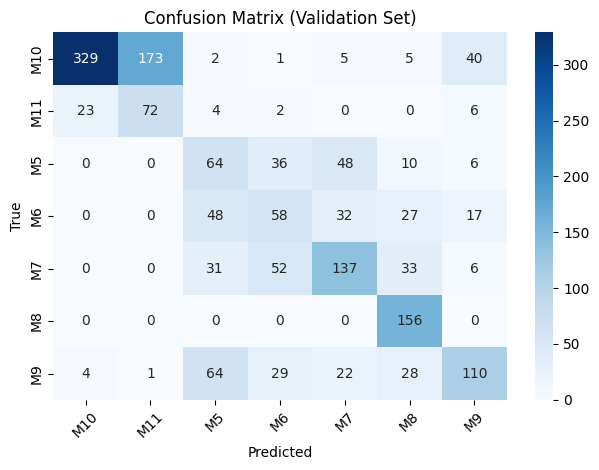

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score


# 拿到最佳模型
best_model = grid_search.best_estimator_

# delete the constant features
val_df = pd.read_csv("/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv")
X_val_raw = val_df[feature_cols]
y_val = val_df["Activity"]

y_pred = best_model.predict(X_val_raw)

# check the Accuracy and F1 score
train_preds = best_model.predict(X_raw)
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, y_pred)
train_f1 = f1_score(y_train, train_preds, average="macro")
val_f1 = f1_score(y_val, y_pred, average="macro")

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Train Macro F1: {train_f1:.4f}")
print(f"Val Macro F1: {val_f1:.4f}")

# ============
# check the balanced accuracy
val_bal_acc = balanced_accuracy_score(y_val, y_pred)
train_bal_acc = balanced_accuracy_score(y_train, train_preds)

print(f"\nTrain Balanced Accuracy: {train_bal_acc:.4f}")
print(f"Val Balanced Accuracy: {val_bal_acc:.4f}")
###

# classification report
print("\nClassification Report: ")
print(classification_report(y_val, y_pred))

# confusion matrix
labels = sorted(np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-----

#### LOSO CV



In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

import warnings
warnings.filterwarnings("ignore")

# 读取并合并 train + val
train_path = "/content/drive/My Drive/final_project/feature_engineering/gender_merged/train_filled.csv"
val_path   = "/content/drive/My Drive/final_project/feature_engineering/gender_merged/val_filled.csv"

train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)
comb_df  = pd.concat([train_df, val_df], ignore_index=True)

# exclude
exclude_cols = [
    "Activity", "Subject", "Window", "set", "trial_id",
    "sex", "most_affected_wrist", "most_affected_ankle", "dominant_side",
    "age", "height_(cm)", "weight_(kg)", "most_affected_side",
    "hoehn_and_yahr_(stage)", "years_since_diagnosis", "cit", "updrs",
    "filename", "subject"
]
feature_cols = [c for c in comb_df.columns if c not in exclude_cols]

X = comb_df[feature_cols]
y = comb_df["Activity"]
groups = comb_df["Subject"]

# 为了在所有输出中保持一致的类别顺序
activity_labels = sorted(y.unique())

# pipeline with model+pyherparameters
loso_pipeline = Pipeline([
    ("var", VarianceThreshold(threshold=0.0)),
    ("scaler", StandardScaler()),
    ("feature_selection", SelectKBest(score_func=f_classif, k=200)),  
    ("classifier", RandomForestClassifier(
        random_state=42,
        n_estimators=250,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=4,
        max_features="log2",
        class_weight=None,   # "balanced"
        n_jobs=-1
    ))
])

# LOSO evaluator
logo = LeaveOneGroupOut()

# pred
y_true_all, y_pred_all = [], []

# 训练端的整体真实-预测 - 观察 过拟合
y_true_train_all, y_pred_train_all = [], []

subjects = comb_df["Subject"].unique()
print(f"Total subjects (folds): {len(subjects)}")

for fold, (train_idx, val_idx) in enumerate(logo.split(X, y, groups), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 训练
    loso_pipeline.fit(X_train, y_train)

    # 训练端预测
    y_pred_train = loso_pipeline.predict(X_train)
    y_true_train_all.extend(y_train)
    y_pred_train_all.extend(y_pred_train)

    # 验证端预测
    y_pred_val = loso_pipeline.predict(X_val)
    y_true_all.extend(y_val)
    y_pred_all.extend(y_pred_val)

# 转为numpy数组
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_true_train_all = np.array(y_true_train_all)
y_pred_train_all = np.array(y_pred_train_all)

# metrics
print("===== LOSO Evaluation (Validation folds aggregated) =====")
print(f"Accuracy: {accuracy_score(y_true_all, y_pred_all):.4f}")
print(f"Macro F1: {f1_score(y_true_all, y_pred_all, average='macro'): .4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true_all, y_pred_all):.4f}")

print("\nClassification Report (Validation):")
print(classification_report(y_true_all, y_pred_all, labels=activity_labels))

# check overfitting
print("\n===== In-fold Training Performance (aggregated) =====")
print(f"Accuracy: {accuracy_score(y_true_train_all, y_pred_train_all):.4f}")
print(f"Macro F1: {f1_score(y_true_train_all, y_pred_train_all, average='macro'): .4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true_train_all, y_pred_train_all):.4f}")

# confusion matrix
cm_counts = confusion_matrix(y_true_all, y_pred_all, labels=activity_labels)
cm_norm   = confusion_matrix(y_true_all, y_pred_all, labels=activity_labels, normalize='true')

##### counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm_counts, display_labels=activity_labels)
fig, ax = plt.subplots(figsize=(7.5, 6))
disp.plot(ax=ax, include_values=True, xticks_rotation=45, colorbar=False, cmap="Blues")
ax.set_title("Confusion Matrix (Counts) - LOSO Validation")
plt.tight_layout()
plt.show()

# Normalized by True
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=activity_labels)
fig, ax = plt.subplots(figsize=(7.5, 6))
disp_norm.plot(ax=ax, include_values=True, xticks_rotation=45, colorbar=True, values_format=".2f", cmap="Blues")
ax.set_title("Confusion Matrix - LOSO Validation")
plt.tight_layout()
plt.show()
